### Blast results analysis
###### *Gurina Alena*

Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import folium

Download dataset with repeats descriprion

In [2]:
repeats_description = pd.read_csv('repeats.csv')

Download blast results to dataframe and rename column (names were get from blast results form description)

In [3]:
blast = pd.read_csv("bl_res_full.txt", sep = '\t', header = None)
blast.columns= ['name', 'match', 'score_perc', 'len', 'mism', 'gap', 'a_st', 'a_end', 's_st', 's_end', 'e_val', 'score_com']

add names too blast_results dataframe for more structured data

In [4]:
spec = []
name_sample = []
match_sample = []
for i in range(0, 136023):
    name_sample.append(blast.iloc[i]['name'].split('_')[0][:5])
    match_sample.append(blast.iloc[i]['match'].split('_')[0])
    spec.append(blast.iloc[i]['name'][0:2])
    
blast['name_sample'] = name_sample #name of sample for which we do blast
blast['match_sample'] = match_sample #name of samle on which blasting sample mached
blast['species'] = spec #name of species for which we do blast

Country distribution of samples from NCBI metadata

In [5]:
Peru = ['Sten1','Phu2s', 'Aj1sh', 'Gon2s', 'Gon3s', 'Gon4s', 'Sten4', 'Sten5', 'Sten6', 'Sten7']
Colombia = ['Sten2', 'Phu3s', 'Phu4s', 'Phu5s', 'Phu6s', 'Sten8']
Bolivia = ['Phu1s', 'Sten3', 'Gon1s']
Ecuador = ['Phu7s']

add information about country to blast results dataframe 

In [6]:
country = []
for i in range(0, len(blast)):
    a = blast.iloc[i]['name_sample']
    if a in Peru:
        country.append('Peru')
    elif a in Colombia:
        country.append('Colombia')
    elif a in Bolivia:
        country.append('Bolivia')
    elif a in Ecuador:
        country.append('Ecuador')
    else:
        raise ValueError
        
blast['country'] = country

Distribution of local blast matches between all repeats show differents in species repeats distribution and also some clusters structure which could be used futher 

<Figure size 432x288 with 0 Axes>

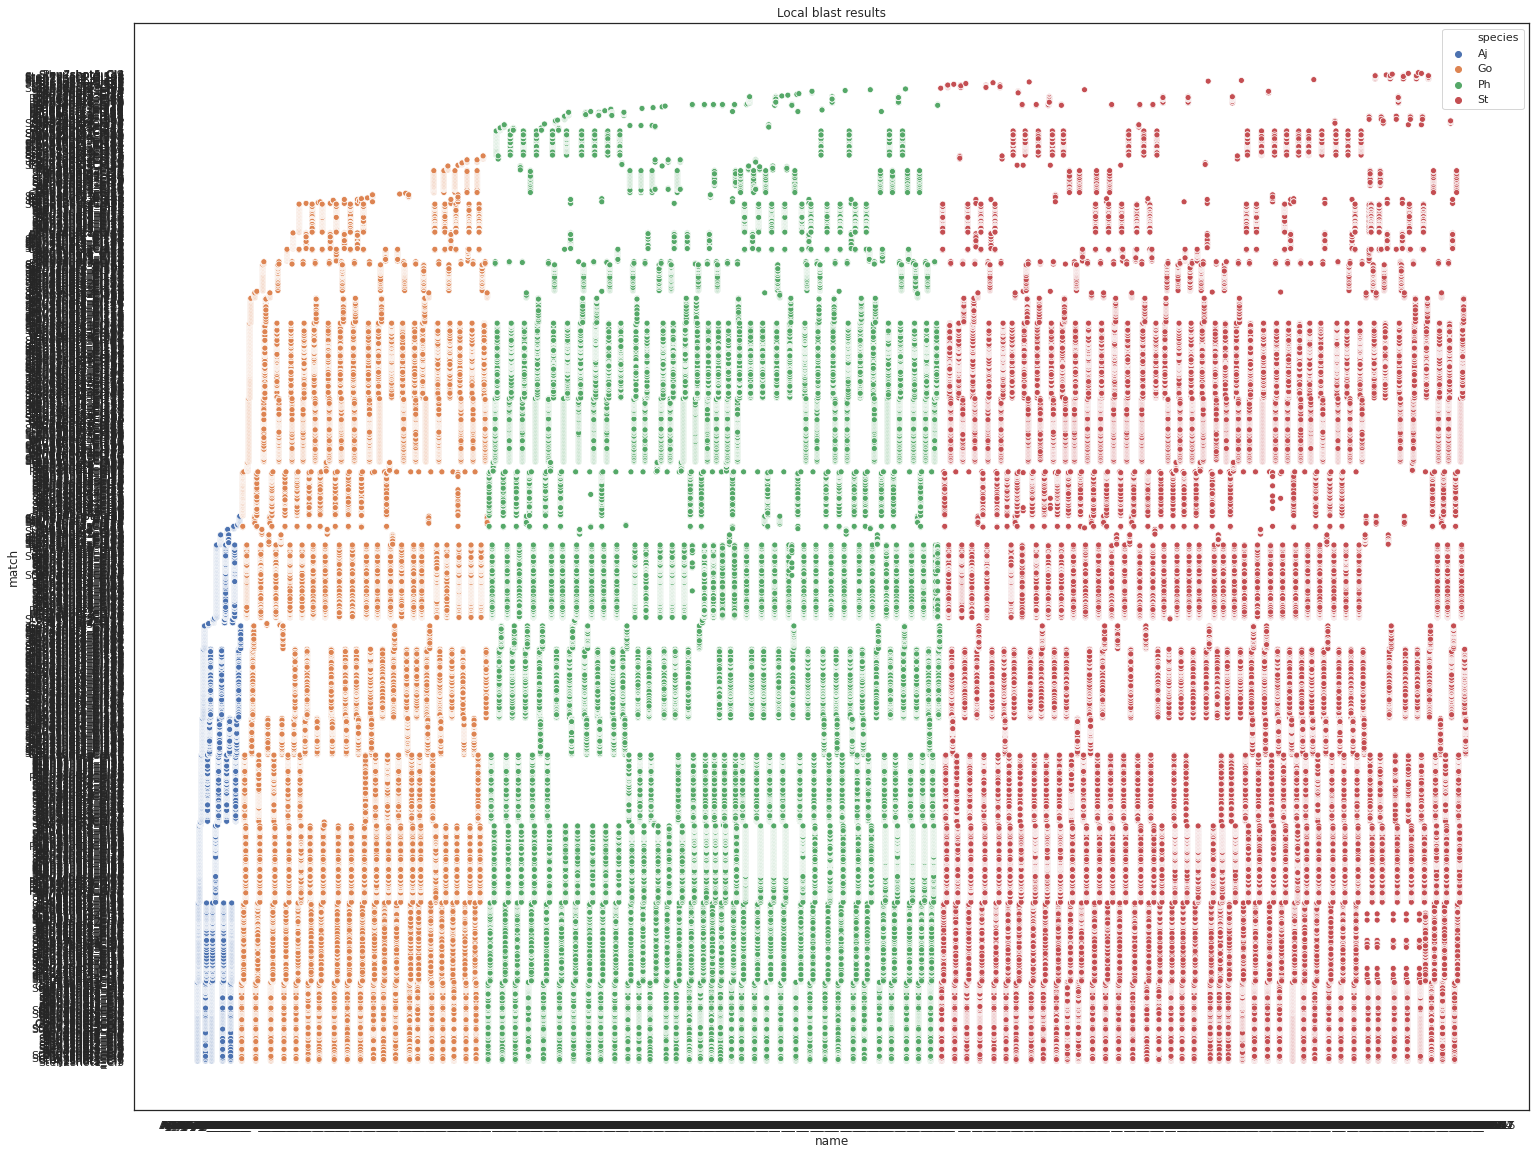

In [7]:
plt.figure()
sns.set(style="white", color_codes=True)
f, axes = plt.subplots(1, figsize=(25, 20))
sns.scatterplot(x = 'name', y = 'match', hue = 'species', data = blast)
plt.title("Local blast results")
plt.savefig("local_blast.png")

Make dataframe where each row and each column will be repeat and in cell will be blast persentage score of simularity <br>
These step takes a lot of time so save results and futher only download dataframe

In [8]:
sim_table = pd.DataFrame(columns = repeats_description['cl_names'], index =repeats_description['cl_names'])
for i in range(0, len(blast)):
    sim_table.loc[blast.loc[i]['name'], blast.loc[i]['match']] = blast.loc[i]['score_perc']
sim_table.to_csv("similarity_table.csv")

In [11]:
sim_table = pd.read_csv("similarity_table.csv")
sim_table.rename(columns={'Unnamed: 0' : 'cluster_names'}, inplace = True)

Add information about samples to similarity dataframe

In [14]:
spec = []
name_sample = []
for i in range(0, 1401):
    name_sample.append(sim_table.iloc[i]['cl_names'].split('_')[0][0:5])
    spec.append(sim_table.iloc[i]['cl_names'].split('_')[0][0:3])
sim_table['species'] = spec
sim_table['sample'] = name_sample

In [15]:
country = []
for i in range(0, 1401):
    a = sim_table.iloc[i]['sample']
    if a in Peru:
        country.append('Peru')
    elif a in Colombia:
        country.append('Colombia')
    elif a in Bolivia:
        country.append('Bolivia')
    elif a in Ecuador:
        country.append('Ecuador')
    else:
        raise ValueError
        
sim_table['country'] = country

fill cells without scores by 0. These cells contain repeats that don't similar each other

In [16]:
sim_table = sim_table.fillna(0)

add information about type of repeats into dataframe

In [18]:
tandem_rank = []
for i in range(0, 1401):
    for j in range(0, 1401):
        if repeats_description.iloc[j]['cl_names'] == sim_table.iloc[i]['cl_names']:
            tandem_rank.append(repeats_description.iloc[j]['tandem_rank']*100)
            break
sim_table['tand_r'] = tandem_rank

Determine optimal number of clusters using k-means clusterisation <br>
And we can see that more shaper decline is after 30

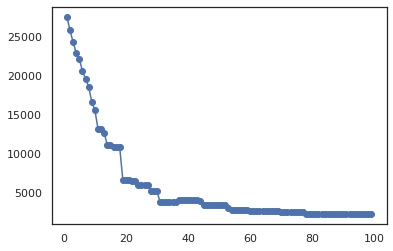

In [21]:
X = sim_table.drop(['cl_names', 'species', 'sample', 'country'], axis = 1)
distortions = []
for i in range(1, 100):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(np.sqrt(km.inertia_))

# plot
plt.plot(range(1, 100), distortions, marker='o')
plt.show()

make clusterisation with 30 clusters

In [22]:
km_res = KMeans(n_clusters=30, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
a = km_res.fit_predict(X)
sim_table['сluster'] = a

on graph we could see: <br>
<ol>
    <li>There is not any cluster that characterized any species (submitted in all samples) and does not found in ither species </li>
    <li>There are clusters represented in all saples and we can use them to compare repeats sequences </li>
    <li>There are clusters of repeats that represented in part of species, and it could be connected with different reasons, one of them is geographic location, which we investigate futher </li>       

<Figure size 432x288 with 0 Axes>

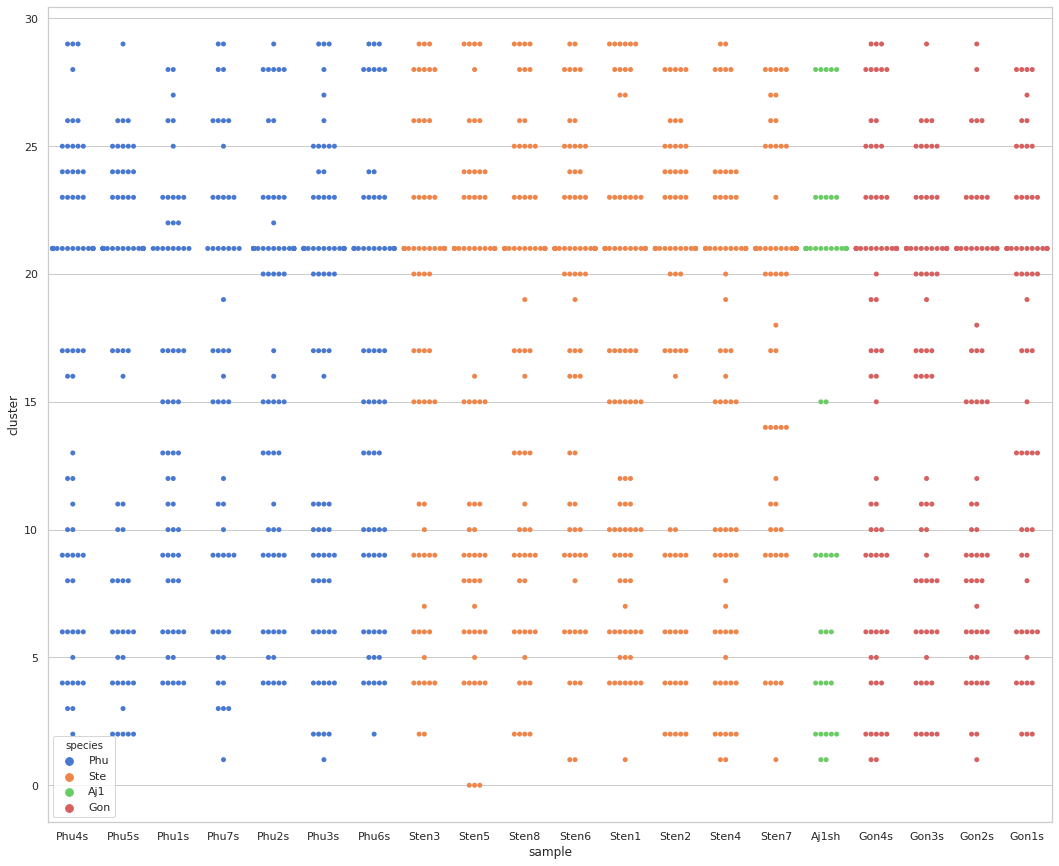

In [23]:
plt.figure()
sns.set(palette="muted")
sns.set_style("whitegrid")
f, axes = plt.subplots(1, figsize=(18, 15))
sns.swarmplot(x = 'sample', y='сluster', hue = 'species', data = sim_table)
plt.savefig("cluster_country.png")

saving results

In [24]:
sim_table.to_csv("sim_table_with_clusters.csv")
blast.to_csv("blast_results.csv")

add information abou repeats cluster in dataframe with repeat description

In [26]:
cluster_km = []
for i in range(0, 1401):
    for j in range(0, 1401):
        if repeats_description.iloc[i]['cl_names'] == sim_table.iloc[j]['cl_names']:
            cluster_km.append(sim_table.iloc[j]['сluster'])
            break
repeats_description['cluster_km'] = cluster_km

we could make subset of interesting us cluster and, for example write fasta file of all sequences in it for futher investigetion

In [27]:
cluster_24 = repeats_description[repeats_description['cluster_km'] == 24]
index = [i for i in range(0, len(cluster_24))]
cluster_24.index = index
for i in range(0, len(cluster_24)):
    name = '>' + str(cluster_24.loc[i]['cl_names'])
    seq = str(cluster_24.loc[i]['seq'])
    with open('cluster_24.fasta', 'a') as out_f:
        out_f.write(name + '\n')
        out_f.write(seq + '\n')

for file Map_coord.csv we use metadata from NCBI to find coordinates of collecting each sample
and also data about is there cluster represented in sample or no
You can see example below

In [28]:
map_coord = pd.read_csv("Map_coord.csv")

In [30]:
map = folium.Map(location=[-12.01,-75.14], zoom_start=5)

for i in range(0, len(map_coord)):
    lat = map_coord.loc[i]["lat"]
    lon = map_coord.loc[i]["lon"]
    label = map_coord.loc[i]["sample"]
    label = folium.Popup(label, parse_html=True)
    if map_coord.loc[i]["k_4"]==1:
        fill_color='#3186cc'
    else:
        fill_color='#f51629'
    folium.CircleMarker(
        [lon, lat],
        radius=5,
        popup=label,
        color=fill_color,
        fill=True,
        fill_color = fill_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
map.save("map_kl_4.html")
map